In [1]:
#경고 끄기
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='Malgun Gothic')

In [3]:
def getData():
    df2008 = pd.read_csv("C:/농수산가격데이터/1001배추/2008010120081231.csv")
    df2009 = pd.read_csv("C:/농수산가격데이터/1001배추/2009010120091231.csv")
    df2010 = pd.read_csv("C:/농수산가격데이터/1001배추/2010010120101231.csv")
    df2011 = pd.read_csv("C:/농수산가격데이터/1001배추/2011010120111231.csv")
    df2012 = pd.read_csv("C:/농수산가격데이터/1001배추/2012010120121231.csv")
    df2013 = pd.read_csv("C:/농수산가격데이터/1001배추/2013010120131231.csv")
    df2014 = pd.read_csv("C:/농수산가격데이터/1001배추/2014010120141231.csv")
    df2015 = pd.read_csv("C:/농수산가격데이터/1001배추/2015010120151231.csv")
    df2016 = pd.read_csv("C:/농수산가격데이터/1001배추/2016010120161231.csv")
    df2017 = pd.read_csv("C:/농수산가격데이터/1001배추/2017010120171231.csv")
    df2018 = pd.read_csv("C:/농수산가격데이터/1001배추/2018010120181231.csv")
    return pd.concat((df2008, df2009, df2010, df2011, df2012, df2013, df2014, df2015, df2016, df2017, df2018), axis=0)

In [4]:
def pricTransform(df):
    #Kg당 가격(kgperprice)
    df['kgperprice'] = ''
    #총거래가격(totalprice) = 거래량(delngQy) * 가격(sbidpric)
    df['totalprice'] = ''
    #총량(totalweight) = 거래단량(delngprut) * 거래량(delngQy) * 단위
    df['totalweight'] = ''

    df11 = df[(df['stdunitnewcode']==11)]
    df12 = df[(df['stdunitnewcode']==12)]
    df13 = df[(df['stdunitnewcode']==13)]
    for df11 in [df11]:
        df11['kgperprice'] = df11['sbidpric'] / df11['delngprut'] * 1000
        df11['totalweight'] = df11['delngprut'] * df11['delngqy'] / 1000
    for df12 in [df12]:
        df12['kgperprice'] = df12['sbidpric'] / df12['delngprut']
        df12['totalweight'] = df12['delngprut'] * df12['delngqy']
    for df13 in [df13]:
        df13['kgperprice'] = df13['sbidpric'] / df13['delngprut'] / 1000
        df13['totalweight'] = df13['delngprut'] * df13['delngqy'] / 1000
    df = pd.concat([df11, df12, df13])

    for df in [df]:
        df['totalprice'] = df['sbidpric'] * df['delngqy']
        
    return df

In [5]:
df = getData()

In [ ]:
df[['sbidpric','aucsecode','aucsenm','delngde','delngprut','delngqy','stdunitnewcode','stdunitnewnm','stdqlitynewcode','stdqlitynewnm','stdspciesnewcode','stdspciesnewnm','stdmtcnewcode','stdmtcnewnm','whsalmrktnewnm']].to_csv('1001.csv', index=False, encoding='utf-8-sig')

### 단량별 가격 sbidpric
- 거래단량 delngprut이 얼마에 거래됬는지 나타내는 변수
- sbidpric만으로는 g, kg, ton 단위가 너무 포괄적이기 때문에 kg당 가격으로 가공 필요

#### 컬럼추가
- Kg당 가격(kgperprice)
  - 가격(sbidpric) / 거래단량(delngprut)
  - 거래단위(stdunitnewcode)가 g(11)일경우 *1000, kg(12)일경우 그대로, ton(13)일경우 /1000
  - 하면 kgperprice가 됨
- 총거래가격(totalprice)
  - 거래량(delngQy) * 가격(sbidpric)
- 총량(totalweight)
  - 거래단량(delngprut) * 거래량(delngQy)
  - 거래단위(stdunitnewcode)가 g(11)일경우 /1000, kg(12)일경우 그대로, ton(13)일경우 *1000

In [6]:
df = pricTransform(df)

(4809379, 47)
(38043, 47)


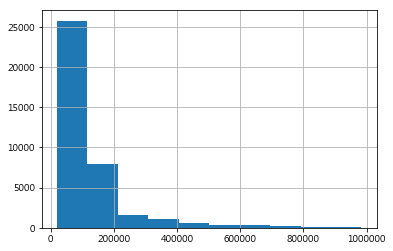

In [7]:
print(df.shape)
print(df[(df['kgperprice'] >= 20000)].shape)
df[(df['kgperprice'] >= 20000)]['kgperprice'].hist()

In [ ]:
# 데이터 가공
# 2만 이상은 결측치라 판단 제거
df = df[(df['kgperprice'] <= 20000)]
# 가격이 100이하 제거
df = df[(df['kgperprice'] >= 100)]

# 근거자료
# https://www.kamis.or.kr/customer/main/main.do

# 무게가 0인 것 제거
df = df[(df['totalweight'] >= 0)]

# 결측값 공백으로 채우기
df['stdmtcnewnm'] = df['stdmtcnewnm'].fillna('')
# 데이터 도별로 구별
df['stdmtcnewnm'] = df['stdmtcnewnm'].map(lambda x: x.split(' ')[0])

df['yyyy'] = df['delngde'].map(lambda x: str(x)[0:4])
df['mm'] = df['delngde'].map(lambda x: str(x)[4:6])
df['dd'] = df['delngde'].map(lambda x: str(x)[6:8])

### 경매 종류 선택 aucsecode-숫자 aucsenm-한글

- 1: 경매

- 2: 정가수의

  - 경쟁계약에 의하지 않고 임의로 상대를 선정하여 계약을 체결하는 것

- 3: 자기계산

  - 가격을 정하고 거래(정가매매)
      1. 출하자 가격과 수량 정해서 도매법인에게 의견전달
      2. 도매법인이 여러 구매자(중도매인, 매매참가인)에게 알려줌
      3. 구매 의향 있는 구매자 등장 시 거래성사

- 4: 매수도매

  - 직접 생산자와 출하약정을 맺고 물량을 구입해 중도매인에게 적정 가격으로 공급하는 제도

In [ ]:
print(df[df['aucsenm'] == '경매'].shape[0]/df['aucsenm'].size)
print(df[df['aucsenm'] == '정가수의'].shape[0]/df['aucsenm'].size)
print(df[df['aucsenm'] == '자기계산'].shape[0]/df['aucsenm'].size)
print(df[df['aucsenm'] == '매수도매'].shape[0]/df['aucsenm'].size)

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df['aucsenm'])

In [ ]:
f, ax = plt.subplots(figsize=(20, 4))
df[['aucsenm','kgperprice']].groupby("aucsenm").mean().sort_values(by='kgperprice', ascending=False).plot.bar(ax=ax)

In [ ]:
pd.DataFrame(df[['aucsenm','totalprice']].groupby("aucsenm").sum().sort_values(by='totalprice', ascending=False)['totalprice'].apply(lambda x: format(int(x), ',')))

In [ ]:
f, ax = plt.subplots(figsize=(20, 4))
df[['aucsenm','totalprice']].groupby("aucsenm").sum().sort_values(by='totalprice', ascending=False).plot.bar(ax=ax)

In [ ]:
pd.DataFrame(df[['aucsenm','totalweight']].groupby("aucsenm").sum().sort_values(by='totalweight', ascending=False)['totalweight'].apply(lambda x: format(int(x), ',')))


In [ ]:
f, ax = plt.subplots(figsize=(20, 4))
df[['aucsenm','totalweight']].groupby("aucsenm").sum().sort_values(by='totalweight', ascending=False).plot.bar(ax=ax)

### 경락일자 delngde
### 거래단량 delngprut
### 거래량 delngqy

### 등급코드 stdqlitynewcode / stdqlitynewnm

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df['stdqlitynewnm'],order = df['stdqlitynewnm'].value_counts().index)

#### 그룹별 중위수 및 평균

In [ ]:
pd.concat([
    df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").median()
    , df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')][['stdqlitynewnm','totalweight']].groupby("stdqlitynewnm").median()
    , df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").mean()
    , df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')][['stdqlitynewnm','totalweight']].groupby("stdqlitynewnm").mean()
] , axis=1)

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdqlitynewnm', y='kgperprice', data=df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')])

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdqlitynewnm', y='totalweight', data=df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')])

In [ ]:
df[((df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')) & (df['totalweight'] <= 0)].shape

In [ ]:
# 10ton 밑으로 재조회
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdqlitynewnm', y='totalweight', data=df[((df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')) & (df['totalweight'] <= 10000)])
print(df[((df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')) & (df['totalweight'] >= 10000)].shape)

#### 그룹별 중위수

In [ ]:
df[(df['stdqlitynewnm'] != '특') & (df['stdqlitynewnm'] != '무등급') & (df['stdqlitynewnm'] != '상') & (df['stdqlitynewnm'] != '보통')][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").median()

#### 그룹별 평균

In [ ]:
df[(df['stdqlitynewnm'] != '특') & (df['stdqlitynewnm'] != '무등급') & (df['stdqlitynewnm'] != '상') & (df['stdqlitynewnm'] != '보통')][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").mean()

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdqlitynewnm', y='kgperprice', data=df[(df['stdqlitynewnm'] != '특') & (df['stdqlitynewnm'] != '무등급') & (df['stdqlitynewnm'] != '상') & (df['stdqlitynewnm'] != '보통')])

### 품종코드 stdspciesnewcode / stdspciesnewnm
- 구품종코드 stdspciescode stdspciesnm
- 품목코드 stdprdlstnewcode / stdprdlstnewnm
- 구품목코드 stdprdlstnm / stdprdlstcode 

In [ ]:
df[['stdspciesnewcode','stdspciesnewnm']].drop_duplicates()

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df['stdspciesnewnm'],order = df['stdspciesnewnm'].value_counts().index)

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdspciesnewnm', y='kgperprice', data=df)

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdspciesnewnm', y='totalweight', data=df)

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdspciesnewnm', y='totalweight', data=df[(df['totalweight'] <= 10000)])

#### 년도별 분포 시각화
- 참고자료 : 1_1. 배추무게분포.ipynb

### 산지코드 stdmtcnewcode / stdmtcnewnm
- 구산지코드 cprmtccode / cprmtcnm

In [ ]:
# 결측값이 너무 많으므로 처리방안 고려 필요
df[df['stdmtcnewnm'] == ''].shape

In [ ]:
# df[['stdmtcnewcode','stdmtcnewnm']].drop_duplicates()
df[['stdmtcnewnm']].drop_duplicates()

In [ ]:
f, ax = plt.subplots(figsize=(20, 4))
df[['stdmtcnewnm','totalweight']].groupby("stdmtcnewnm").sum().sort_values(by='totalweight', ascending=False).plot.bar(ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(20, 4))
df[['stdmtcnewnm','totalprice']].groupby("stdmtcnewnm").sum().sort_values(by='totalprice', ascending=False).plot.bar(ax=ax)

### 단위코드 stdunitnewcode / stdunitnewnm

In [ ]:
df[['stdunitnewcode','stdunitnewnm']].drop_duplicates()

In [ ]:
sns.countplot(df['stdunitnewnm'])

In [ ]:
sns.countplot(df[(df['stdunitnewcode'] != 12)]['stdunitnewnm'])

### 시장코드 whsalmrktnewcode / whsalmrktnewnm
- 구시장코드 whsalmrktcode / whsalmrktnm 
- 가락시장 코드 1005601(신) 110001(구)

In [ ]:
f, ax = plt.subplots(figsize=(20, 4))
df[['whsalmrktnewnm','totalweight']].groupby("whsalmrktnewnm").sum().sort_values(by='totalweight', ascending=False).plot.bar(ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(20, 4))
df[['whsalmrktnewnm','totalprice']].groupby("whsalmrktnewnm").sum().sort_values(by='totalprice', ascending=False).plot.bar(ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(10, 4))
sns.distplot(df['kgperprice'])

In [ ]:
# 로그스케일링 histogram
f, ax = plt.subplots(figsize=(10, 4))
sns.distplot(np.log1p(df['kgperprice']))

In [ ]:
new_df = pd.concat((df[['kgperprice','yyyy','mm']].groupby(['yyyy','mm']).mean(), df.groupby(['yyyy','mm'])[['totalprice','totalweight']].sum()), axis=1)

In [ ]:
import datetime as dt
from dateutil.relativedelta import relativedelta
yyyymm_1 = '200801'
yyyymm_2 = '201812'

MONTH = relativedelta(months=+1)

fmt = '%Y%m'
date_1 = dt.datetime.strptime(yyyymm_1, fmt).date()
date_2 = dt.datetime.strptime(yyyymm_2, fmt).date()

yyyymm = []
while date_1 <= date_2:
    yyyymm.append(date_1.strftime('%Y')+date_1.strftime('%m'))
    date_1 += MONTH

In [ ]:
new_df = pd.DataFrame(new_df.values)

In [ ]:
new_df['yyyy'] = new_df['date'].map(lambda x: str(x)[0:4])
new_df['mm'] = new_df['date'].map(lambda x: str(x)[4:6])

In [ ]:
new_df[new_df['yyyy']=='2008']

In [ ]:
f, ax = plt.subplots(15,0)
ax = sns.lineplot(x="mm", y=0 , data=new_df[new_df['yyyy']=='2008'])

In [ ]:
yyyy = sorted(new_df['yyyy'].unique())

In [ ]:
type(yyyy[0])

In [ ]:
new_df[new_df['yyyy']=='2018']

In [ ]:
yyyy = sorted(new_df['yyyy'].unique())
f, ax = plt.subplots(20,0)
for i, v in enumerate(yyyy):
    ax = sns.lineplot(x="mm", y=0, data=new_df[new_df['yyyy']==v])

In [ ]:
new_df = pd.concat((df[['kgperprice','yyyy','mm']].groupby(['yyyy','mm']).mean(), df.groupby(['yyyy','mm'])[['totalprice','totalweight']].sum()), axis=1)

In [ ]:
mean_of_month_1 = 